<hr> 

# Trajectory Sub Segment Analysis
author, date = p.caldas@fct.unl.pt, August 2021 Version

<hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import gridspec
import seaborn as sns
import sys
import os 
from scipy.spatial.distance import cdist, pdist, mahalanobis
from functools import reduce
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from scipy.spatial import ConvexHull

### Functions Utils

In [2]:
def read_trackmate_xml_tracks(xml_file):
    """Reads tracks from trackmate xml track file and converts into a user-friendly DataFrame """
    from xml.etree import cElementTree as ET
    tracks = ET.parse(xml_file)
    frame_interval = float(tracks.getroot().attrib["frameInterval"])
    n_tracks = float(tracks.getroot().attrib["nTracks"])
    
    attributes = []
    for ti, track in enumerate(tracks.iterfind('particle')):
        for spots in track.iterfind('detection'):
            attributes.append([ti, int(spots.attrib.get('t')),
                                   float(spots.attrib.get('x')),
                                   float(spots.attrib.get('y'))])

    track_table = pd.DataFrame(attributes, columns=['TRACK_ID','FRAME','POSITION_X','POSITION_Y'])
    return track_table, frame_interval, n_tracks

def FilterTracks(traj_table, minlen):
    '''filter tracks shorter than minlen (in frames)'''
    
    traj_table = traj_table.groupby('TRACK_ID').filter(lambda track: track.TRACK_ID.count() > minlen)
    
    # create a dictionary to attribute a new number to each track ID
    new_ids = {}
    for i, value in enumerate(traj_table.TRACK_ID.unique()):
        new_ids[value] = i
    
    # replace existent IDs with new ID's using the dicitonary above
    traj_table['TRACK_ID'].replace(new_ids, inplace = True)
    
    # reset index (just in case)
    traj_table.reset_index(drop = True, inplace = True)
    
    return traj_table

def color_pick_diff(p, colors = ['steelblue','orange','crimson']):
    if p >= 0.1:
        color = colors[1]
    else:
        color = colors[2]
    return color

def color_pick_msd(p, colors = ['steelblue','orange','crimson']):
    if p >= 1.2:
        color = colors[0]
    elif p > 0.6 and p < 1.2:
        color = colors[1]
    else:
        color = colors[2]
    return color

def color_pick_confRatio(p, thres = 5, colors = ['steelblue','orange','crimson']):
    if p >= thres:
        color = colors[2]
    elif p < thres:
        color = colors[1]
    return color

def color_pick_phi(p, colors = ['steelblue','orange','crimson']):
    if p >= 0.8:
        color = colors[0]
    elif p > 0.2 and p < 0.8:
        color = colors[1]
    else:
        color = colors[2]
    return color

### Functions to Measure Directionality

In [3]:
def ComputeMSD(trajectory, frame_interval, coords = ['POSITION_X','POSITION_Y'], clip_fit = 0.5):
    """Compute MSD stats for one trajectory 
    returns taus, msd_curve, taus_fit, msd_fit, alpha, msd_params, mode
    
    frame_interval: in seconds 
    coords: in microns 
    """
    
    msd_curve = []
    n_shifts = len(trajectory)
    
    for shift in range(1, n_shifts):
        diffs = abs(trajectory[coords] - trajectory[coords].shift(-shift))
        msd = np.square(diffs.dropna()).sum(axis=1)
        msd_curve.append(msd.mean())  
    
    taus = np.array(range(1,n_shifts)) * frame_interval
    
    # fit linear equation to find the scalling exponent (alpha)
    
    np.insert(taus, 0, 0) 
    np.insert(msd_curve, 0,0)
    
    clip = int(len(msd_curve) * clip_fit)
    
    eq_linear = lambda t, alpha, d: alpha * t + d
    (alpha, d), cov1 = curve_fit(eq_linear, np.log(taus[:clip]), np.log(msd_curve[:clip]), p0 = (0.5,0.5), 
                                                                                    bounds= ([0, -np.inf],[np.inf,np.inf]))
    
    # fit to a parabola with a diffusion (D) and velocity (V) component if alpha >> 1.2 (directed motion)
        
    if alpha >= 10:

        mode = 'directed'

        eq_parabola = lambda t, D, V: 4*D*t + ((V**2) * (t**2))
        
        msd_params, cov_vel = curve_fit(eq_parabola, taus[:clip], msd_curve[:clip], p0 = (0.5,0.5),
                                                             bounds= ([0, 0],[np.inf,np.inf]))
        # return attributes for active transport
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_parabola(taus_fit, *msd_params)        
    
    # fit to a linear equation with only a diffusion (D) component if alpha is around 1 (Brownian motion)
    
    elif alpha > 0.6 and alpha < 10:

        mode = 'random'

        eq_linear2 = lambda t, D: 4*D*t
        msd_params, cov_dif = curve_fit(eq_linear2, taus[:clip], msd_curve[:clip], p0 = 0.5, bounds= (0, np.inf))    

        # return attributes for Brownian diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_linear2(taus_fit, *msd_params)

    # fit to a linear equation with only a diffusion (D) component if alpha is around 1 (Brownian motion)

    else:
        mode = 'confined'

        eq_confined = lambda t,D,R: (R**2) * (1 - np.exp(-(4*D*t)/(R**2)))
        msd_params, cov_conf = curve_fit(eq_confined, taus[:clip], msd_curve[:clip],
                                        p0 = (0.5,0.5), bounds= ([0,0],[np.inf, np.inf]))    

        # return attributes for confined diffusion
        taus_fit = np.linspace(0, taus[-1], 500)
        msd_fit = eq_confined(taus_fit, *msd_params)
        
    return taus, msd_curve, taus_fit, msd_fit, alpha, msd_params, mode

def ComputeDirectionality(track_table, coord = ['POSITION_X','POSITION_Y']):
    '''estimates distance, displacement and directionality for a given track '''

    steps = []
    
    for frame in range(1,len(track_table)):
        step_dist = np.linalg.norm(track_table[coord].iloc[frame] - (track_table[coord].iloc[frame-1]))
        steps.append(step_dist)

    displacement = np.linalg.norm(track_table[coord].iloc[0] - track_table[coord].iloc[-1])
    distance = np.sum(steps)
    directionality = displacement/np.sum(steps)
    
    return distance, displacement, directionality

### Functions to Measure Confinement Area

In [4]:
def ComputeSquareDisplacement(track_table, coord = ['POSITION_X','POSITION_Y']):
    '''estimates the sum of square distances along step size of a given track '''
    
    steps = []
    
    for frame in range(1,len(track_table)):
        step_dist = np.linalg.norm(track_table[coord].iloc[frame] - (track_table[coord].iloc[frame-1]))
        steps.append(step_dist**2) #append squared distances between time points
    
    # sum all squared distances between time points
    square_displacement = np.sum(steps)
    
    return square_displacement

def FitElipse(track_table, X='POSITION_X', Y = 'POSITION_Y'):
    '''Fits and elipse around all data points
    returns elipse coordinates and area of the convex hull surroding data points'''
    
    # get convex hull for data points
    hull = ConvexHull(track_table[[X,Y]]) 
    
    # use hull vertices to get area around the data points
    x = track_table.reset_index(drop = True).iloc[hull.vertices].POSITION_X
    y = track_table.reset_index(drop = True).iloc[hull.vertices].POSITION_Y
    
    # smooth area around the data points with an elipse
    
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/len(y)) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    
    return fit, hull.volume

def ConfinementRatio(track_table, X='POSITION_X', Y = 'POSITION_Y'):
    ''' relates the sum of the square displacements between successive time points 
    by the total surface area of the track '''
    
    squared_distances = ComputeSquareDisplacement(track_table)
    cage, cage_area = FitElipse(track_table, X = X, Y = Y) 
    
    segment_pc = squared_distances/(cage_area**2)
    
    return segment_pc

### Read XML data - Filter Tracks
- Filter Short Tracks (in frames)

In [5]:
file = 'data/trajectories/LA_Time_Lapse_23.06.2021_12_57_25_Exp3_51ms_p2_Tracks.xml'

table, rate, n_tracks = read_trackmate_xml_tracks(file)
table = FilterTracks(table, 30)

'{} tracks after filtering'.format(len(table.TRACK_ID.unique()))

'161 tracks after filtering'

### Pick one track to visualize

track with 196 steps


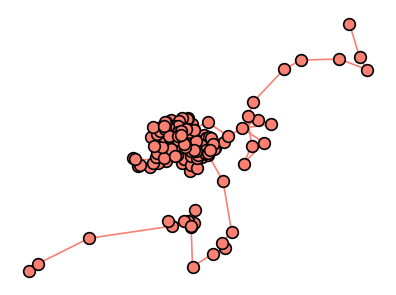

In [6]:
# pick data set to analyze; pick a track number
data = table
frame_interval = rate
i = 76

# track selection
track = data[data.TRACK_ID == i]
print('track with {} steps'.format(len(track)))

fig, ax = plt.subplots(figsize = (4,3), dpi = 120)
plt.plot(track.POSITION_X, track.POSITION_Y, '-o', lw = 1, color = 'salmon', markersize = 7, markeredgecolor = 'black'); plt.axis('off');

### Run Function - Rolling Window Confinement Ratio

rolling windows: [10, 20, 30] frames


AttributeError: 'DataFrame' object has no attribute 'POSITION_X'

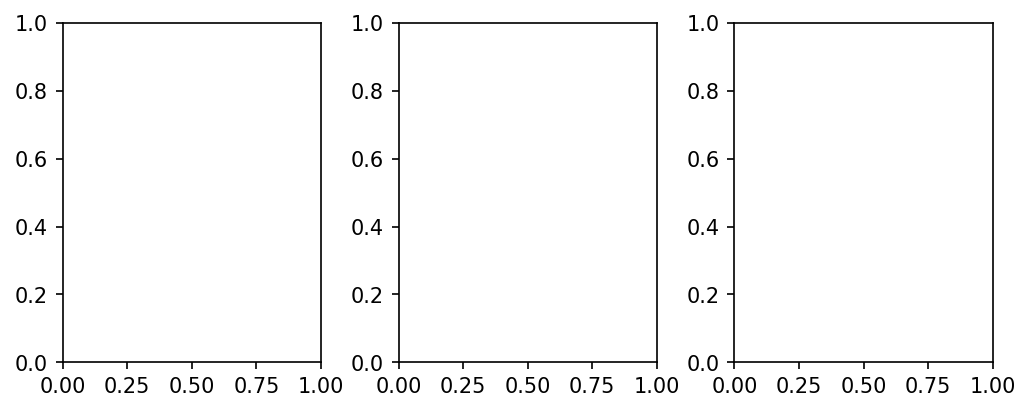

In [31]:
# rolling window size (convert 1 second window into frames) 
min_window = (int(np.ceil(1/frame_interval)))
windows = [min_window, min_window*2, min_window*3]

windows = [10, 20, 30]
conf_thres = 1500
print('rolling windows: {} frames'.format(windows))

# lists to store output variables of each sub-segment
alphas = []       # msd scalling factor
phis   = []       # directionality ratio
diff_coeffs = []  # diffusion coefficients
conf_ratios = []  # confinement ratio

# plot window to add sub segments
fig, ax = plt.subplots(1,3, figsize = (8,3), dpi = 150)
plt.subplots_adjust(wspace = 0.3)

# run statistics on sucessive sliding windows

for i, window_size in enumerate(windows, start = 1):
    
    print('rolling window {0} : {1:.4} sec'.format(i, window_size * frame_interval), end ="\r")
    
    for window in np.arange(0, track.shape[0] - window_size, 1):
       
        X = track.POSITION_X.iloc[window: window + window_size + 1]
        Y = track.POSITION_Y.iloc[window: window + window_size + 1]

        segment = pd.DataFrame([X,Y]).T # segment to analyze
        
        # compute msd - save scalling factor (alpha) and diffusion constante of each segment (diff_coeff)
        taus, msds, taus_fit, msds_fit, alpha, msd_params, mode = ComputeMSD(segment, frame_interval, clip_fit = 0.8)
        
        alphas.append([alpha, window_size])
        diff_coeffs.append([msd_params[0],window_size])
        
        # compute confinement ratio
        conf_ratio = ConfinementRatio(segment)
        conf_ratios.append([conf_ratio,window_size])
        
        # compute directionality ratio (phi)
        phi = ComputeDirectionality(segment)[2]
        phis.append([phi,window_size])

        # plot trajectory - color code according to confinement ratio
        ax[0].plot(X,Y, '-o', lw = 0.5, markersize = 5, markeredgecolor = 'black', color = color_pick_msd(alpha), alpha = 0.5)
        ax[0].set_xlabel('X ($\mu m$)'); ax[0].set_ylabel('Y ($\mu m$)')
        #ax[0].set_aspect(aspect = 'equal')
        ax[0].axis('off')
               
        # plot trajectory - color code according to directionality ratio
        ax[1].plot(X,Y, '-o', lw = 0.5, markersize = 5, markeredgecolor = 'black', color = color_pick_phi(phi), alpha = 0.5)
        ax[1].set_xlabel('X ($\mu m$)'); ax[1].set_ylabel('Y ($\mu m$)')
        #ax[0].set_aspect(aspect = 'equal')
        ax[1].axis('off')      
        
        # plot trajectory - color code according to confinement ratio
        ax[2].plot(X,Y, '-o', lw = 0.5, markersize = 5, markeredgecolor = 'black', color = color_pick_confRatio(conf_ratio, thres = conf_thres), alpha = 0.5)
        ax[2].set_xlabel('X ($\mu m$)'); ax[2].set_ylabel('Y ($\mu m$)')
        #ax[0].set_aspect(aspect = 'equal')
        ax[2].axis('off')
        
#draw initital position of the trajectory
ax[0].plot(track.POSITION_X.iloc[0], track.POSITION_Y.iloc[0], 'o', markerfacecolor = 'cyan', markeredgecolor = 'black', markersize = 6)
ax[0].set_title('msd scalling factor (alpha)'.format(ComputeDirectionality(track)[0]), fontsize = 9)

ax[1].plot(track.POSITION_X.iloc[0], track.POSITION_Y.iloc[0], 'o', markerfacecolor = 'cyan', markeredgecolor = 'black', markersize = 6)
ax[1].set_title('directionality ratio (phi)'.format(ComputeDirectionality(track)[0]), fontsize = 9)

ax[2].plot(track.POSITION_X.iloc[0], track.POSITION_Y.iloc[0], 'o', markerfacecolor = 'cyan', markeredgecolor = 'black', markersize = 6)
ax[2].set_title('confinement ratio (p)'.format(ComputeDirectionality(track)[0]), fontsize = 9);

### Plot Parameter Fluctuation for each Sub Segment

In [11]:
def plotParameterVSrollingWindow(param, name = 'alpha', thres = 5):
    rol_windows = np.unique([j for i,j in param])
    df = pd.DataFrame(param, columns=[name,'window_size'])
    
    fig, ax = plt.subplots(figsize = (9, 3), dpi = 120)
    
    for w in rol_windows:
        x = np.arange(0, df[df['window_size'] == w].shape[0])
        y = df[df['window_size'] == w][name]
        
        plt.plot(x,y, lw= 1.2, label = w, color = plt.cm.viridis(w*5))
    
    plt.legend(title= "rol wind size", fontsize=7, title_fontsize=7, loc = 0, frameon = True)
    ax.set_xlabel('rolling window start position (#)'); 
    ax.set_ylabel(name);
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));
    
    # threhsold for confinement ratio
    plt.hlines(y = thres, xmin = np.min(x), xmax = np.max(x), alpha = 0.2, ls = '--', color = 'gray')

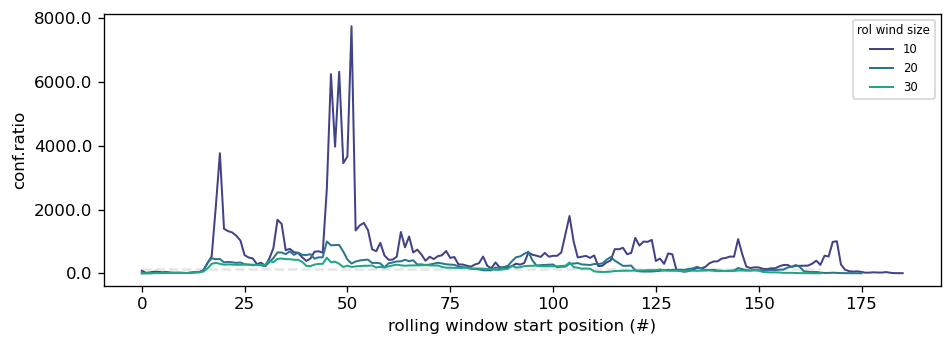

In [13]:
plotParameterVSrollingWindow(conf_ratios, name = 'conf.ratio', thres = 150)

### Plot Normalized Parameters

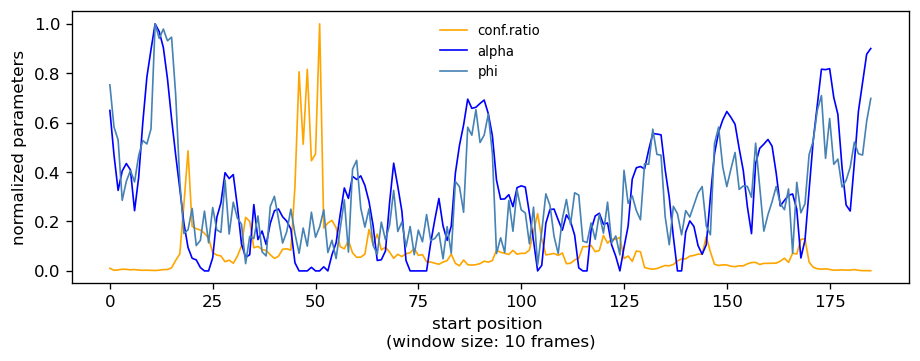

In [330]:
#param = conf_ratios
#name = 'conf.ratio'
w = 10

# transform each output into a data frame to select only the window sizes we want
conf_ratios_df = pd.DataFrame(conf_ratios, columns=['conf.ratios','window_size'])
alpha_df = pd.DataFrame(alphas, columns=['alpha','window_size'])
phi_df = pd.DataFrame(phis, columns=['phi','window_size'])

# x values to plot
conf_ratios_wind = conf_ratios_df[conf_ratios_df['window_size'] == w].reset_index()['conf.ratios']
alpha_wind = alpha_df[alpha_df['window_size'] == w].reset_index()['alpha']
phi_wind = phi_df[phi_df['window_size'] == w].reset_index()['phi']

# plot normalized values
fig, ax = plt.subplots(figsize = (9,3), dpi = 120)
plt.plot(conf_ratios_wind/conf_ratios_wind.max(), lw = 1, color = 'orange', label = 'conf.ratio')
plt.plot(alpha_wind/alpha_wind.max(), lw= 1, color = 'blue', label = 'alpha')
plt.plot(phi_wind/phi_wind.max(), lw = 1, color = 'steelblue', label = 'phi')

plt.legend(frameon = False, fontsize = 8)
ax.set_xlabel('start position \n(window size: {} frames)'.format(w)); 
ax.set_ylabel('normalized parameters');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));

### Visualize SubSegment

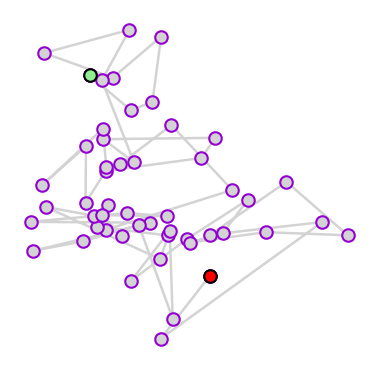

In [333]:
start = 25
end = 75

# plot window to add sub segments
track = track.reset_index(drop=True)
segment_to_plot = track.loc[start:end]

fig, ax = plt.subplots(figsize = (3,3), dpi = 150)
plt.plot(segment_to_plot.POSITION_X, segment_to_plot.POSITION_Y,
        '-o', lw = 1.2, markersize = 6, markeredgecolor = 'darkviolet', color = 'lightgray', alpha = 1)

ax.plot(segment_to_plot.POSITION_X.iloc[0], segment_to_plot.POSITION_Y.iloc[0], 'o', markerfacecolor = 'lightgreen', markeredgecolor = 'black', markersize = 6)
ax.plot(segment_to_plot.POSITION_X.iloc[-1], segment_to_plot.POSITION_Y.iloc[-1], 'o', markerfacecolor = 'red', markeredgecolor = 'black', markersize = 6)

ax.set_xlabel('X ($\mu m$)'); ax.set_ylabel('Y ($\mu m$)'); ax.axis('off');

## Build Main Function - Search for Confined SubSegments

In [20]:
def ComputeConfinementRatioScore(track = track, conf_ratio_thres = 5, rol_window = 10, coords = ['POSITION_X','POSITION_Y']):

    windows = [rol_window]

    conf_ratio_matrix = []

    for i, window_size in enumerate(windows, start = 1):

        #print('rolling window: {0:.4} sec'.format(window_size * frame_interval))

        for window in np.arange(0, track.shape[0] - window_size, 1):

            X = track.POSITION_X.iloc[window: window + window_size + 1]
            Y = track.POSITION_Y.iloc[window: window + window_size + 1]

            segment = pd.DataFrame([X,Y]).T # segment to analyze

            # compute confinement ratio
            conf_ratio = ConfinementRatio(segment)

            # add parameters to respective lists
            conf_ratio_segment = segment.copy()
            conf_ratio_segment['conf_ratio_w' + str(window_size)] = conf_ratio

            conf_ratio_segment_first = conf_ratio_segment[~conf_ratio_segment.duplicated(conf_ratio_segment.columns[-1])]
            conf_ratio_matrix.append(conf_ratio_segment_first)

        # Combine all matrix in one; colpase NaN values
        conf_ratio_matrix_merged = reduce(lambda X,Y: pd.merge(X,Y, on = coords, how = 'outer'), conf_ratio_matrix)
        conf_ratio_matrix_reduced = pd.concat([conf_ratio_matrix_merged.iloc[:,:2], conf_ratio_matrix_merged.iloc[:,2:].mean(axis = 1)], axis = 1)
        conf_ratio_matrix_reduced.columns = coords + list(['conf_ratio'])

        # add column with a mode label for each data point: free diffusion or confined

        mode = []

        for val in conf_ratio_matrix_reduced['conf_ratio']:
            if val > conf_ratio_thres: mode.append(True)
            else: mode.append(False)

        conf_ratio_matrix_reduced['confined'] = mode
        
    return conf_ratio_matrix_reduced

def FindTransitionPoints(track_score, col = 'confined'):
    
    score_matrix = track_score.copy()

    # first and last datapoint are always added to the list
    transition_points = [0, len(score_matrix)]

    # for each transition between modes, consider a transition point
    for i, row in score_matrix.iloc[:-1].iterrows():
        if score_matrix[col].iloc[i+1] != score_matrix[col].iloc[i]:
            transition_points.append(i+1)

    transition_points = np.unique(transition_points)

    return transition_points

def DenoiseTransitionPoints(track_scored, transition_points, col = 'confined', min_len = 10):
    '''This function finds transition points along column 'col' and ignores short subsegments
    returns score_matrix with only significant transitions'''

    track_scored = track_scored.copy()

    confined_tracks_index = []

    for i, pos in enumerate(transition_points[:-1]):

        sub_segment = track_scored.iloc[transition_points[i]:transition_points[i+1]]

        if len(sub_segment) >= min_len and sub_segment[col].iloc[-1] == True:
            confined_tracks_index.append(sub_segment.index.values)
        
        #if len(sub_segment) <= 3 and sub_segment[col].iloc[-1] == False:
        #    confined_tracks_index.append(sub_segment.index.values)

    # combine multiple segment indexes into a list
    confined_tracks_index = [i for j in confined_tracks_index for i in j]

    # re-name column col for true confined spots
    track_scored.loc[confined_tracks_index, col] = True
    track_scored.loc[~track_scored.index.isin(confined_tracks_index), col] = False # False for eve
    
    return track_scored

def PlotConfinedRegions(track, track_scored, col = 'confined'):
    
    fig, ax = plt.subplots(figsize = (3,3), dpi = 150)
    
    # plot all points from raw track in gray 
    
    X = track.POSITION_X
    Y = track.POSITION_Y
    
    plt.plot(X, Y,'--o', lw = 1.2, markersize = 6, markeredgecolor = 'black', color = 'lightgray', alpha = 1)
    
    # color in red the confined data points from the scored track table 
    
    for i, row in track_scored.iterrows():
        
        X_confined = row.POSITION_X
        Y_confined = row.POSITION_Y
            
        if row[col] == True: color = 'crimson'
        else: color = 'orange'
    
        plt.plot(X_confined, Y_confined,'o', lw = 1.2, markersize = 6, markeredgecolor = 'black', 
        markeredgewidth = 1, color = color, alpha = 1)
        
    # add starting point and end point
    plt.plot(X.iloc[0], Y.iloc[0], 'o', markerfacecolor = 'lightgreen', markeredgecolor = 'black', markersize = 6)
    plt.plot(X.iloc[-1], Y.iloc[-1], 'o', markerfacecolor = 'purple', markeredgecolor = 'black', markersize = 6)

    # format plot
    ax.set_xlabel('X ($\mu m$)'); ax.set_ylabel('Y ($\mu m$)'); ax.axis('off');
    
def PlotConfinedAreas(track, track_scored, col = 'confined'):
    
    track_scored = track_score_denoised
    trans_points = FindTransitionPoints(track_scored)

    fig, ax = plt.subplots(figsize = (3,3), dpi = 150) 

    X = track.POSITION_X
    Y = track.POSITION_Y
    
    plt.plot(X, Y,'--o', lw = 1.2, markersize = 6, markeredgecolor = 'black', color = 'lightgray', alpha = 1)

    for i, pos in enumerate(trans_points[:-1]):
        sub_segment = track_scored.iloc[trans_points[i]:trans_points[i+1]]

        if sub_segment[col].iloc[-1] == True:

            cage, cage_area = FitElipse(sub_segment)

            plt.plot(cage[0, :], cage[1, :], '--r', alpha = 0.7, label = 'cage size')
        
    # add starting point and end point
    plt.plot(X.iloc[0], Y.iloc[0], 'o', markerfacecolor = 'lightgreen', markeredgecolor = 'black', markersize = 6)
    plt.plot(X.iloc[-1], Y.iloc[-1], 'o', markerfacecolor = 'purple', markeredgecolor = 'black', markersize = 6)

    # format plot
    ax.set_xlabel('X ($\mu m$)'); ax.set_ylabel('Y ($\mu m$)'); ax.axis('off');
    
    
def ComputeSubSegmentStats(track_score_denoised, transition_points, rate, col = 'confined'):
    '''computes the lifetime, cage area and other parameters of each subsegment in track_score_denoised (in seconds)
    using the transition points in the column col. 
    
    returns a data frame with all parameters for each segment along the track
    
    params:
    track_score_denoised: trajectory table containing a column col
    col: column, boolean, weather a given spot is in confined motion or not
    '''
    
    params = []
    
    for i, pos in enumerate(transition_points[:-1]):

        sub_segment = track_score_denoised.iloc[transition_points[i]:transition_points[i+1]]

        # compute lifetime of each subsegment
        lifetime = sub_segment.shape[0] * rate

        # compute cage area of each subsegment - only if segment if larger than 3 steps 
        # free difussion segments can have less than 5 frames sometimes ...
        
        if sub_segment.shape[0] > 5: 
            cage_area = FitElipse(sub_segment)[1] * 1000 # in nanometer
        else: 
            cage_area = np.nan
            
        # compute total distance of each subsegment
        
        if sub_segment.shape[0] > 5:
            dist = ComputeDirectionality(sub_segment)[0] # in micron
        else: 
            dist = np.nan
            
        # add parameters to list
        
        if sub_segment[col].iloc[0] == True:
            params.append(['confined', lifetime, cage_area, dist, sub_segment.shape[0]])
        else:
            params.append(['free_diff', lifetime, cage_area, dist, sub_segment.shape[0]])      
            
    return pd.DataFrame(params, columns=['mode','lifetime (s)','cage_area (nm2)', 'distance (um)', 'steps'])

### Pick a track number

track with 132 steps


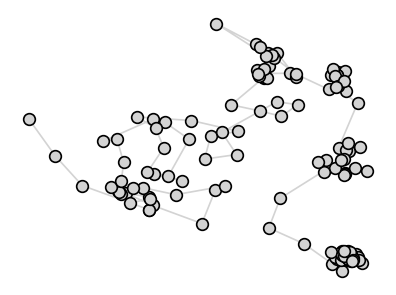

In [386]:
# pick data set to analyze; pick a track number
data = table
frame_interval = rate
i = 26

# track selection
track = data[data.TRACK_ID == i]
print('track with {} steps'.format(len(track)))

fig, ax = plt.subplots(figsize = (4,3), dpi = 120)
plt.plot(track.POSITION_X, track.POSITION_Y, '-o', lw = 1, color = 'lightgrey', markersize = 7, markeredgecolor = 'black'); plt.axis('off');

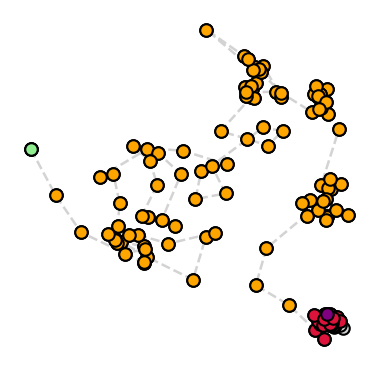

In [389]:
track_score = ComputeConfinementRatioScore(track, conf_ratio_thres = 500, rol_window = 10)
track_score_denoised = DenoiseTransitionPoints(track_score, FindTransitionPoints(track_score))
PlotConfinedRegions(track, track_score_denoised)
#PlotConfinedAreas(track, track_score_denoised)

In [391]:
track_stats = ComputeSubSegmentStats(track_score_denoised, FindTransitionPoints(track_score_denoised), rate)
track_stats

,mode,lifetime (s),cage_area (nm2),distance (um),steps
0,free_diff,4.998,1430.928564,11.557997,98
1,confined,1.224,10.333018,1.087764,24


In [361]:
track_score_denoised.head(30)

,POSITION_X,POSITION_Y,conf_ratio,confined
0,54.065136,7.473805,268.653844,False
1,54.079622,7.525634,244.370819,False
2,54.044245,7.490222,116.021456,False
3,54.029225,7.475558,116.050133,False
4,54.031428,7.430174,129.068716,False
5,54.197292,7.445057,173.168128,False
6,54.167686,7.453834,256.608282,True
7,54.138182,7.480587,416.479493,True
8,54.071353,7.564861,1181.109366,True
9,54.083081,7.584604,815.871779,True


### Analyze All Tracks

In [17]:
def AnalyzeAllTracks(table, frame_rate, tracks = -1, window_size = 10, p_thres = 5):
    
    print('rolling window: {0:.4} sec'.format(window_size * frame_rate))
    
    table = table.copy()
    
    # truncate number of tracks to analyze; default is -1 to analyze eveything
    
    if tracks == -1: 
        table = table

    else:
        trunc = table[table['TRACK_ID'] == (tracks-1)].index[-1]
        table = table.iloc[:trunc]
    
    # run all function for each track
    
    all_tracks_stats = []
    
    for i, track in table.groupby('TRACK_ID'):
           
        # check if trajectory is just noise (i.e empty tracks)
            
        noise = (track[~track.duplicated(['POSITION_X', 'POSITION_Y'])].shape[0] < 10)
        
        if noise == False:
        
            print('track {}/{} - {} steps'.format(i+1, len(table.TRACK_ID.unique()), track.shape[0]), end = '\r')

            try: 
                track_score = ComputeConfinementRatioScore(track, conf_ratio_thres = p_thres, rol_window = window_size)
                track_score_denoised = DenoiseTransitionPoints(track_score, FindTransitionPoints(track_score))
                track_stats = ComputeSubSegmentStats(track_score_denoised, FindTransitionPoints(track_score_denoised), rate)

                all_tracks_stats.append(track_stats)

            except:
                continue
    
    return all_tracks_stats

### Select XML file

In [21]:
file = 'data/trajectories/LA_Time_Lapse_23.06.2021_12_57_25_Exp3_51ms_p2_Tracks.xml'

table, rate, n_tracks = read_trackmate_xml_tracks(file)
table = FilterTracks(table, 30)

'{} tracks after filtering'.format(len(table.TRACK_ID.unique()))

'161 tracks after filtering'

In [27]:
all_tracks_stats = AnalyzeAllTracks(table, rate, tracks = 100)

rolling window: 0.51 sec


### How many trajectories show confined motion

In [28]:
tracks_w_confinement = 0
tracks_lifetimes_confined = []
tracks_lifetimes_free = []

for track in all_tracks_stats:
    
    if 'confined' in track['mode'].values:
        tracks_w_confinement += 1
    
    confined_lifetimes = track[track['mode'] == 'confined']['lifetime (s)'].values
    free_lifetimes = track[track['mode'] == 'free_diff']['lifetime (s)'].values
    
    tracks_lifetimes_confined.append(confined_lifetimes)
    tracks_lifetimes_free.append(free_lifetimes)
    
# unpack lists
tracks_lifetimes_confined = [i for j in tracks_lifetimes_confined for i in j]
tracks_lifetimes_free = [i for j in tracks_lifetimes_free for i in j]

'tracks with confined regions: 99/99'

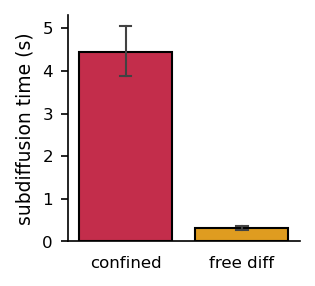

In [30]:
fig, ax = plt.subplots(figsize = (2,2), dpi = 150)
mycolors = ['crimson','orange','steelblue']

track_motion = pd.DataFrame([tracks_lifetimes_confined, tracks_lifetimes_free],
                            index = ['confined','free diff']).T

sns.barplot(data = track_motion, ax = ax, palette = mycolors, edgecolor = 'black', 
            linewidth = 1, errwidth=1, capsize=0.1)

# fancy stuff
ax.set_ylabel('subdiffusion time (s)', fontsize = 9); #ax.set_xlabel('type of motion', fontsize = 11);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.tick_params(direction = 'out', top=False, right = False, bottom = False, labelsize=8)
#ax.set_ylim([0,3]);

# 
'tracks with confined regions: {}/{}'.format(tracks_w_confinement, len(all_tracks_stats))